## 卷积神经网络 Convolutional Neural Networks

<img src="data/logo.png" alt="Drawing" style="width: 300px;"/>

在这个课程项目中，我们接触学习卷积神经网络(CNNs)并将它运用到自然语言处理(NLP)的任务中。CNN一般被使用于图像相关的机器学习任务中, [这里]((https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) 有一些相关教程。我们还是会先做一些文本处理任务，CNN的表现也足够惊艳。

## 概览

这篇 [论文](https://arxiv.org/abs/1510.03820) 中的这张图显示了1维卷积是怎么应用于句子中的词语的。 

<img src="data/cnn_text.png" alt="Drawing" style="width: 800px;"/>

* **目的:** 从输入数据中检测空间数据

* **优点:**
	* 权重数量比较少(被分享)
	* 可平行的
	* 可检测出多维空间子结构(特征提取)
	* 应用过滤器可以有较好解释性
	* 可应用在图像处理，文字处理，时间序列处理 等等
* **缺点:**
	* 较多超参数 (卷积核大小, 步长, 等等)
	* 输入的数据形状应该一样 (图片维度, 文本长度等等)
* **其他:**
	* 许多深度卷积神经构架经常会为了达到最好的性能(state of the art)做更新。

## 过滤器

卷积神经网络的核心是过滤器(或者权重，卷积核，等等叫法)会在输入数据上进行卷积操作(滑动)来获取相关特征。过滤器也是随机初始化的，但之后随着训练的过程 "学会" 从输入数据提取帮助优化模型的有效特征。这里会用较为非常规的方法讲解CNN，因为我们只会将它运用于2维的文本数据。每个输入都由词语组成，然后我们会把每个词语都做独热编码处理，从而得到二维的输入。这么做是因为，每个过滤器都会代表一种特征，我们会将这个过滤器运用到别的输入上从而获取相同的特征。这也叫做共享参数(parameter sharing)。



<img src="data/conv.gif" alt="Drawing" style="width: 500px;"/>


In [1]:
import torch
import torch.nn as nn


这里输入是一批二维文本数据。让我们先来制造一组有64个采样的输入，其中每个采样有8个词，而每个词又由长度为10的数组表示(词大小为10的独热编码)。这就构成了大小是(64, 8, 10)的输入。[PyTorch的CNN模块](https://pytorch.org/docs/stable/nn.html#convolution-functions) 默认的输入中通道维度(channel dim)，在我们的例子中就是独热向量的维度，是在第二位的，所以输入的形状就是(64, 10, 8)。


<img src="data/cnn_text1.png" alt="Drawing" style="width: 500px;"/>


In [2]:
# 假设所有输入都有同样多的词语数量
batch_size = 64
sequence_size = 8 # 每个输入的词语数
one_hot_size = 10 # vocab size (num_input_channels)
x = torch.randn(batch_size, one_hot_size, sequence_size)
print("Size: {}".format(x.shape))

Size: torch.Size([64, 10, 8])


然后我们就会开始用过滤器对输入进行卷积操作。参考下面的图片，为了更加简明扼要，这里只用了5个大小是 (1,2) 的过滤器，而且深度和信道数一样 (都是10)，所以过滤器的形状是 (5, 2, 10), 和前面一样，我们将它变形为 (5, 10, 2)

<img src="data/cnn_text2.png" alt="Drawing" style="width: 500px;"/>


In [3]:
# 创建过滤器
out_channels = 5 # 过滤器数量
kernel_size = 2 # 大小
conv1 = nn.Conv1d(in_channels=one_hot_size, out_channels=out_channels, kernel_size=kernel_size)
print("Size: {}".format(conv1.weight.shape))
print("Filter size: {}".format(conv1.kernel_size[0]))
print("Padding: {}".format(conv1.padding[0]))
print("Stride: {}".format(conv1.stride[0]))

Size: torch.Size([5, 10, 2])
Filter size: 2
Padding: 0
Stride: 1


应用这个过滤器，我们会得到大小是 (64, 5, 7) 的输出。64 是这批数据大小，5 是信道维度因为我们用了5个过滤器，7 是卷积输出，算法如下:

~$\frac{W - F + 2P}{S} + 1 = \frac{8 - 2 + 2(0)}{1} + 1 = 7~$

其中 :
  * W: 输入宽度
  * F: 过滤器大小
  * P: 内边距
  * S: 步长


<img src="data/cnn_text3.png" alt="Drawing" style="width: 500px;"/>


In [4]:
# 使用过滤器进行卷积
conv_output = conv1(x)
print("Size: {}".format(conv_output.shape))

Size: torch.Size([64, 5, 7])


## 池化
我们将卷积的结果成为 **特征图(feature map)** 。由于卷积和交叉的特性，特征图里会携带许多冗余信息。 **池化(Pooling)** 操作可以讲高维的特征图进行有效降维。

<img src="data/pool.jpeg" alt="Drawing" style="width: 500px;"/>


In [5]:
# 最大池化
kernel_size = 2
pool1 = nn.MaxPool1d(kernel_size=kernel_size, stride=2, padding=0)
pool_output = pool1(conv_output)
print("Size: {}".format(pool_output.shape))

Size: torch.Size([64, 5, 3])


~$\frac{W-F}{S} + 1 = \frac{7-2}{2} + 1 =  \text{floor }(2.5) + 1 = 3~$

## 使用卷积神经网络处理文本信息

我们将在文本数据上使用卷积神经网络，核心概念是在表示单个字符的向量组上进行卷积来获取有意义的 [n-gram](https://blog.csdn.net/songbinxu/article/details/80209197#n-gram%E7%AE%80%E4%BB%8B) 信息。

你可以简单的直接应用这样的配置来处理 [时间序列数据](https://arxiv.org/abs/1807.10707) 或和其他网络 [结合](https://arxiv.org/abs/1808.04928)。 对于文本数据来说，我们会创建不同大小的过滤器，(1,2), (1,3), (1,4) 作为不同大小 n-gram 的特征选择器。他们的输出会被拼接并输入一个全连接层(fully-connected-layer)用作类别判断。我们在这里将会对词语中的字母使用一维卷积，而在 [嵌入层](https://www.kesci.com/home/project/share/50c13cecc0bf7ba1) 这个项目中，我们会对句子中的单词作一维卷积。

**词嵌入:** 找到相邻词条(token)中的暂时关系，这些暂时关系暗示了某些词语代表了相似的意义。比如 "New Jersey" 和 "NJ" 和 "Garden State" 有相似意思，他们都指新泽信这个地方。
**字符嵌入:** 创建词语在字符级别的关联。比如 "toy" 和 "toys" 意思相近。


## 配置

In [6]:
import os
from argparse import Namespace
import collections
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [7]:
# 设置Numpy和PyTorch随机种子
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# 创建字典
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [8]:
# 参数
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="data/names.csv",
    split_data_file="data/split_names.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="names",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    num_epochs=20,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    num_filters=100,
    dropout_p=0.1,
)

# 设置种子
set_seeds(seed=args.seed, cuda=args.cuda)

# 创建保存文件夹
create_dirs(args.save_dir)

# 拓展文件路径
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# 检查GPU可用性
if torch.cuda.is_available():
    args.cuda = True
else:
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda), "device: {}".format(args.device))

Using CUDA: False device: cpu


## 数据

In [9]:
import re
import urllib

In [10]:
# 未处理数据
df = pd.read_csv(args.data_file, header=0)
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [11]:
# 按国籍切分数据集
by_nationality = collections.defaultdict(list)
for _, row in df.iterrows():
    by_nationality[row.nationality].append(row.to_dict())
for nationality in by_nationality:
    print ("{0}: {1}".format(nationality, len(by_nationality[nationality])))

English: 2972
French: 229
Arabic: 1603
Russian: 2373
Japanese: 775
Chinese: 220
Italian: 600
Czech: 414
Irish: 183
German: 576
Greek: 156
Spanish: 258
Polish: 120
Dutch: 236
Vietnamese: 58
Korean: 77
Portuguese: 55
Scottish: 75


In [12]:
# 新建切分数据集
final_list = []
for _, item_list in sorted(by_nationality.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # 给每个数据点添加子集属性
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    #添加到最新的列表
    final_list.extend(item_list)

In [13]:
# 切分后的数据集dataframe
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    7680
test     1660
val      1640
Name: split, dtype: int64

In [14]:
# 预处理
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
split_df.surname = split_df.surname.apply(preprocess_text)

In [15]:
# 存入CSV
split_df.to_csv(args.split_data_file, index=False)
split_df.head()

,nationality,split,surname
0,Arabic,train,bishara
1,Arabic,train,nahas
2,Arabic,train,ghanem
3,Arabic,train,tannous
4,Arabic,train,mikhail


## 词汇表

In [16]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        # 词条转换为索引
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # 索引转换为词条
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}
        
        # 添加未知词条
        self.add_unk = add_unk
        self.unk_token = unk_token
        if self.add_unk:
            self.unk_index = self.add_token(self.unk_token)

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx,
                'add_unk': self.add_unk, 'unk_token': self.unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        if self.add_unk:
            index = self.token_to_idx.get(token, self.unk_index)
        else:
            index =  self.token_to_idx[token]
        return index

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [17]:
# 词汇表实例
nationality_vocab = Vocabulary(add_unk=False)
for index, row in df.iterrows():
    nationality_vocab.add_token(row.nationality)
print (nationality_vocab) # __str__
index = nationality_vocab.lookup_token("English")
print (index)
print (nationality_vocab.lookup_index(index))

<Vocabulary(size=18)>
0
English


## 向量器

In [18]:
class SurnameVectorizer(object):
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        one_hot_matrix_size = (len(surname), len(self.surname_vocab))
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
                               
        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[position_index][character_index] = 1
        
        return one_hot_matrix
    
    def unvectorize(self, one_hot_matrix):
        len_name = len(one_hot_matrix)
        indices = np.zeros(len_name)
        for i in range(len_name):
            indices[i] = np.where(one_hot_matrix[i]==1)[0][0]
        surname = [self.surname_vocab.lookup_index(index) for index in indices]
        return surname

    @classmethod
    def from_dataframe(cls, df):
        surname_vocab = Vocabulary(add_unk=True)
        nationality_vocab = Vocabulary(add_unk=False)

        # 创建词汇表
        for index, row in df.iterrows():
            for letter in row.surname: # 字符级词条化
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab, nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

In [19]:
# 向量器实例
vectorizer = SurnameVectorizer.from_dataframe(split_df)
print (vectorizer.surname_vocab)
print (vectorizer.nationality_vocab)
vectorized_surname = vectorizer.vectorize(preprocess_text("goku"))
print (np.shape(vectorized_surname))
print (vectorized_surname)
print (vectorizer.unvectorize(vectorized_surname))

<Vocabulary(size=28)>
<Vocabulary(size=18)>
(4, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
['g', 'o', 'k', 'u']


**注意**: 和MLP时的独热编码不同，这里我们成功保存了和姓相关的结构信息。这是因为我们这次用的是字符，并且有很大的词汇表来处理文本，这个方法并不永远可靠。在接下来的课程项目中里我们将会探索 **嵌入法**。

## 数据集

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
class SurnameDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, split_data_file):
        df = pd.read_csv(split_data_file, header=0)
        train_df = df[df.split=='train']
        return cls(df, SurnameVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, split_data_file, vectorizer_filepath):
        df = pd.read_csv(split_data_file, header=0)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        surname_vector = self.vectorizer.vectorize(row.surname)
        nationality_index = self.vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'surname': surname_vector, 'nationality': nationality_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, collate_fn, shuffle=True, 
                         drop_last=True, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size,
                                collate_fn=collate_fn, shuffle=shuffle, 
                                drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [22]:
# 数据集实例
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.split_data_file)
print (dataset) # __str__
print (np.shape(dataset[5]['surname'])) # __getitem__
print (dataset.class_weights)

<Dataset(split=train, size=7680)
(6, 28)
tensor([0.0006, 0.0045, 0.0024, 0.0042, 0.0003, 0.0044, 0.0017, 0.0064, 0.0055,
        0.0017, 0.0013, 0.0130, 0.0083, 0.0182, 0.0004, 0.0133, 0.0039, 0.0172])


## 模型

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class SurnameModel(nn.Module):
    def __init__(self, num_input_channels, num_output_channels, num_classes, dropout_p):
        super(SurnameModel, self).__init__()
        
        # 卷积权重
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, num_output_channels, 
                                             kernel_size=f) for f in [2,3,4]])
        self.dropout = nn.Dropout(dropout_p)
       
        # 全连接层权重
        self.fc1 = nn.Linear(num_output_channels*3, num_classes)

    def forward(self, x, channel_first=False, apply_softmax=False):
        
        # 重新
        if not channel_first:
            x = x.transpose(1, 2)
            
        # 卷积输出
        z = [conv(x) for conv in self.conv]
        z = [F.max_pool1d(zz, zz.size(2)).squeeze(2) for zz in z]
        z = [F.relu(zz) for zz in z]
        
        # 连接卷积输出
        z = torch.cat(z, 1)
        z = self.dropout(z)

        # 全连接层
        y_pred = self.fc1(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

## 训练

**内距:** 同一批的输入信息需要有相同的形状大小。向量器将token转化为向量形式，但是在某一个特别的数据批次中，我们可能会有不同大小的数据输入。解决方案是找到最大的数据，并且将其他数据填充至一样的大小，一般我们会对较小的数据填充 0 值向量。

训练时，训练类的 批生成器(batch generater) `generate_batches` 函数生成数据采样，我们用 `collate_fn` 找到最大的输入，用`pad_seq`函数进行填充操作，直到所有数据都有相同的大小。

In [25]:
import torch.optim as optim

In [26]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # 打印训练checkpoint
        print ("[EPOCH]: {0:02d} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # 至少保存一次模型
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # 如果模型性能表现有提升，再次保存
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # 如果损失增大
            if loss_t >= self.train_state['early_stopping_best_val']:
                # 更新early stop的步数
                self.train_state['early_stopping_step'] += 1

            # 损失变小
            else:
                # 保存最优的模型
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # 重置early stopping 的步数
                self.train_state['early_stopping_step'] = 0

            # 是否需要early stop ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
    
    def pad_seq(self, seq, length):
        vector = np.zeros((length, len(self.dataset.vectorizer.surname_vocab)),
                          dtype=np.int64)
        for i in range(len(seq)):
            vector[i] = seq[i]
        return vector
    
    def collate_fn(self, batch):
        
        # 深度拷贝
        batch_copy = copy.deepcopy(batch)
        processed_batch = {"surname": [], "nationality": []}
        
        # 获取最长数据
        max_seq_len = max([len(sample["surname"]) for sample in batch_copy])
        
        # 填充
        for i, sample in enumerate(batch_copy):
            seq = sample["surname"]
            nationality = sample["nationality"]
            padded_seq = self.pad_seq(seq, max_seq_len)
            processed_batch["surname"].append(padded_seq)
            processed_batch["nationality"].append(nationality)
            
        # 转化为合适的tensor
        processed_batch["surname"] = torch.FloatTensor(
            processed_batch["surname"]) # 这里需要浮点数
        processed_batch["nationality"] = torch.LongTensor(
            processed_batch["nationality"])
        
        return processed_batch    
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # 在训练集上遍历

            # 初始化批生成器, 将损失和准确率归零，设置为训练模式
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn,
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # 梯度归零
                self.optimizer.zero_grad()

                # 计算输出
                y_pred = self.model(batch_dict['surname'])

                # 计算损失
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # 反向传播
                loss.backward()

                # 更新梯度
                self.optimizer.step()
                
                # 计算准确率
                acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # 遍历 val 集

            # 初始化批生成器, 将损失和准确率归零，设置为训练模式
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # 计算输出
                y_pred =  self.model(batch_dict['surname'])

                # 计算损失
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # 计算准确率
                acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # 始化批生成器, 将损失和准确率归零，设置为运行模式
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, collate_fn=self.collate_fn,
            shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 计算输出
            y_pred =  self.model(batch_dict['surname'])

            # 计算损失
            loss = self.loss_func(y_pred, batch_dict['nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 计算准确率
            acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # 设置图大小
        plt.figure(figsize=(15,5))

        # 画出损失
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # 画出准确率
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # 存图
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # 展示图
        plt.show()
    
    def save_train_state(self):
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [27]:
# 初始化
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.split_data_file)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = SurnameModel(num_input_channels=len(vectorizer.surname_vocab),
                     num_output_channels=args.num_filters,
                     num_classes=len(vectorizer.nationality_vocab),
                     dropout_p=args.dropout_p)
print (model.named_modules)

<bound method Module.named_modules of SurnameModel(
  (conv): ModuleList(
    (0): Conv1d(28, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(28, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(28, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=18, bias=True)
)>


In [28]:
# 训练
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 2.82 | [TRAIN ACC]: 20.2% | [VAL LOSS]: 2.71 | [VAL ACC]: 37.1%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 2.54 | [TRAIN ACC]: 43.9% | [VAL LOSS]: 2.40 | [VAL ACC]: 49.8%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 2.18 | [TRAIN ACC]: 48.7% | [VAL LOSS]: 2.12 | [VAL ACC]: 48.2%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 1.88 | [TRAIN ACC]: 51.1% | [VAL LOSS]: 1.90 | [VAL ACC]: 50.6%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 1.67 | [TRAIN ACC]: 54.8% | [VAL LOSS]: 1.74 | [VAL ACC]: 50.6%
[EPOCH]: 05 | [LR]: 0.001 | [TRAIN LOSS]: 1.52 | [TRAIN ACC]: 57.4% | [VAL LOSS]: 1.65 | [VAL ACC]: 55.8%
[EPOCH]: 06 | [LR]: 0.001 | [TRAIN LOSS]: 1.37 | [TRAIN ACC]: 60.0% | [VAL LOSS]: 1.60 | [VAL ACC]: 60.4%
[EPOCH]: 07 | [LR]: 0.001 | [TRAIN LOSS]: 1.28 | [TRAIN ACC]: 62.2% | [VAL LOSS]: 1.53 | [VAL ACC]: 59.8%
[EPOCH]: 08 | [LR]: 0.001 | [TRAIN LOSS]: 1.20 | [TRAIN ACC]: 62.9% | [VAL LOSS]: 1.49 | [VAL ACC]: 58.5%
[EPOCH]: 09 | [LR]: 0.001 | [TRAIN LOSS]: 1.12

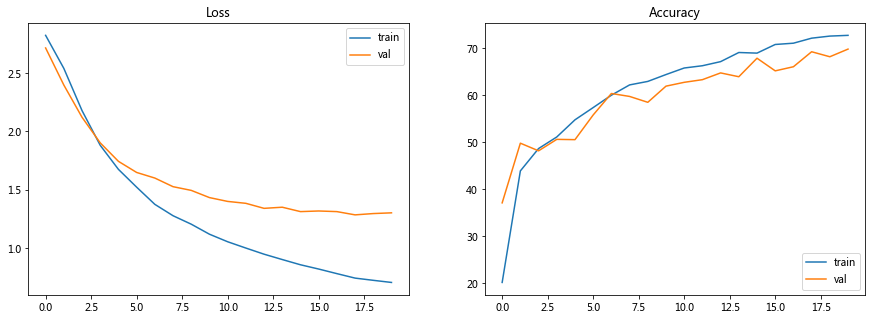

In [29]:
# 画出性能
trainer.plot_performance()

In [30]:
# 测试集上的性能
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 1.30
Test Accuracy: 68.3%


In [31]:
# 保存结果
trainer.save_train_state()

## 预测

In [32]:
class Inference(object):
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
  
    def predict_nationality(self, surname):
        # 向前传播
        vectorized_surname = torch.tensor(self.vectorizer.vectorize(surname)).unsqueeze(0)
        self.model.eval()
        y_pred = self.model(vectorized_surname, apply_softmax=True)

        # 可能性最高的国籍
        y_prob, indices = y_pred.max(dim=1)
        index = indices.item()

        # 预测出的国籍
        nationality = vectorizer.nationality_vocab.lookup_index(index)
        probability = y_prob.item()
        return {'nationality': nationality, 'probability': probability}
  
    def predict_top_k(self, surname, k):
        # 向前传播
        vectorized_surname = torch.tensor(self.vectorizer.vectorize(surname)).unsqueeze(0)
        self.model.eval()
        y_pred = self.model(vectorized_surname, apply_softmax=True)

        # 最有可能的K个国籍
        y_prob, indices = torch.topk(y_pred, k=k)
        probabilities = y_prob.detach().numpy()[0]
        indices = indices.detach().numpy()[0]

        # 结果
        results = []
        for probability, index in zip(probabilities, indices):
            nationality = self.vectorizer.nationality_vocab.lookup_index(index)
            results.append({'nationality': nationality, 'probability': probability})

        return results

In [33]:
# 加载模型
dataset = SurnameDataset.load_dataset_and_load_vectorizer(
    args.split_data_file, args.vectorizer_file)
vectorizer = dataset.vectorizer
model = SurnameModel(num_input_channels=len(vectorizer.surname_vocab),
                     num_output_channels=args.num_filters,
                     num_classes=len(vectorizer.nationality_vocab),
                     dropout_p=args.dropout_p)
model.load_state_dict(torch.load(args.model_state_file))
model = model.to("cpu")
print (model.named_modules)

<bound method Module.named_modules of SurnameModel(
  (conv): ModuleList(
    (0): Conv1d(28, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(28, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(28, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=18, bias=True)
)>


In [34]:
# 预测
inference = Inference(model=model, vectorizer=vectorizer)
surname = input("Enter a surname to classify: ")
prediction = inference.predict_nationality(preprocess_text(surname))
print("{} → {} (p={:0.2f})".format(surname, prediction['nationality'], 
                                    prediction['probability']))

Enter a surname to classify: kakeawq
kakeawq → Japanese (p=0.30)


In [35]:
# 可能性最高的k个预测
top_k = inference.predict_top_k(preprocess_text(surname), 
                                k=len(vectorizer.nationality_vocab))
for result in top_k:
    print ("{} → {} (p={:0.2f})".format(surname, result['nationality'], 
                                         result['probability']))

kakeawq → Japanese (p=0.30)
kakeawq → Polish (p=0.28)
kakeawq → Dutch (p=0.11)
kakeawq → Czech (p=0.10)
kakeawq → English (p=0.06)
kakeawq → Russian (p=0.05)
kakeawq → Arabic (p=0.04)
kakeawq → Greek (p=0.03)
kakeawq → German (p=0.01)
kakeawq → Chinese (p=0.01)
kakeawq → Irish (p=0.00)
kakeawq → Scottish (p=0.00)
kakeawq → French (p=0.00)
kakeawq → Korean (p=0.00)
kakeawq → Portuguese (p=0.00)
kakeawq → Spanish (p=0.00)
kakeawq → Vietnamese (p=0.00)
kakeawq → Italian (p=0.00)


## 批标准化 Batch normalization

在开始训练前，我们已经对数据进行了诸如零均值，单位方差等标准化操作来帮助模型收敛。输入数据在训练过程中，经过隔层网络和各种非线性变换，显然是一直在变化的。这种情况被称作 内协变量偏移 (internal covariate shift 没有正式的中文翻译)，这种情况的发生会使训练变慢，这时候需要我们降低学习率。通用的解决方案是做 [批标准化处理 batch normalization](https://arxiv.org/abs/1502.03167) (batchnorm)，让标准化成为模型构架的一部分。

~$BN = \frac{a - \mu_{x}}{\sqrt{\sigma^2_{x} + \epsilon}}  * \gamma + \beta~$

where:
* ~$a~$ = 激活 | ~$\in \mathbb{R}^{NXH}~$ (~$N~$ 样本数量, ~$H~$ 隐藏维度)
* ~$\mu_{x}~$ = 隐藏维度的均值 | ~$\in \mathbb{R}^{1XH}~$
* ~$\sigma^2_{x}~$ = 隐藏维度的方差 | ~$\in \mathbb{R}^{1XH}~$
* ~$epsilon~$ = 噪声
* ~$\gamma~$ = 规模参数 (通过学习得到)
* ~$\beta~$ = 偏移参数 (通过学习得到)

但是在激活之前将输入标准化又有什么意义呢？批标准化操作只作用于隐藏的维度上( 我们这里是`num_output_channels` )，并不会作用于整个激活矩阵。每一个隐藏维度的均值和方差都会使用当前批所有数据样本进行计算，训练中批标准化还会用到激活矩阵的均值和方差。但是测试中，样本大小会出现偏差，所以一般模型会使用在训练过程中存下来的均值和方差。PyTorch 的 [`BatchNorm`类](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm1d) 已经帮我们处理好了这个问题。

<img src="data/layernorm.png" alt="Drawing" style="width: 500px;"/>


In [36]:
# 带批标准化的模型
class SurnameModel_BN(nn.Module):
    def __init__(self, num_input_channels, num_output_channels, num_classes, dropout_p):
        super(SurnameModel_BN, self).__init__()
        
        # 卷积权重
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, num_output_channels, 
                                             kernel_size=f) for f in [2,3,4]])
        self.conv_bn = nn.ModuleList([nn.BatchNorm1d(num_output_channels) # define batchnorms
                                      for i in range(3)])
        self.dropout = nn.Dropout(dropout_p)
       
        # 全连接层权重
        self.fc1 = nn.Linear(num_output_channels*3, num_classes)

    def forward(self, x, channel_first=False, apply_softmax=False):
        
        # 转换输入格式
        if not channel_first:
            x = x.transpose(1, 2)
            
        # 卷积输出
        z = [F.relu(conv_bn(conv(x))) for conv, conv_bn in zip(self.conv, self.conv_bn)]
        z = [F.max_pool1d(zz, zz.size(2)).squeeze(2) for zz in z]
        
        # 拼接卷积输出
        z = torch.cat(z, 1)
        z = self.dropout(z)

        # 全连接层
        y_pred = self.fc1(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

In [37]:
# 初始化
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.split_data_file)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = SurnameModel_BN(num_input_channels=len(vectorizer.surname_vocab),
                        num_output_channels=args.num_filters,
                        num_classes=len(vectorizer.nationality_vocab),
                        dropout_p=args.dropout_p)
print (model.named_modules)

<bound method Module.named_modules of SurnameModel_BN(
  (conv): ModuleList(
    (0): Conv1d(28, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(28, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(28, 100, kernel_size=(4,), stride=(1,))
  )
  (conv_bn): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=18, bias=True)
)>


训练这个带有 batchnorm 的模型后会发现在验证集上的性能提高了大约 2~5 %

In [38]:
# 训练
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 2.62 | [TRAIN ACC]: 22.5% | [VAL LOSS]: 2.33 | [VAL ACC]: 40.4%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 2.01 | [TRAIN ACC]: 43.5% | [VAL LOSS]: 1.92 | [VAL ACC]: 49.6%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 1.64 | [TRAIN ACC]: 50.6% | [VAL LOSS]: 1.73 | [VAL ACC]: 46.5%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 1.39 | [TRAIN ACC]: 56.4% | [VAL LOSS]: 1.52 | [VAL ACC]: 58.8%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 1.21 | [TRAIN ACC]: 61.2% | [VAL LOSS]: 1.52 | [VAL ACC]: 52.5%
[EPOCH]: 05 | [LR]: 0.001 | [TRAIN LOSS]: 1.09 | [TRAIN ACC]: 62.7% | [VAL LOSS]: 1.40 | [VAL ACC]: 58.0%
[EPOCH]: 06 | [LR]: 0.001 | [TRAIN LOSS]: 0.97 | [TRAIN ACC]: 65.0% | [VAL LOSS]: 1.38 | [VAL ACC]: 55.8%
[EPOCH]: 07 | [LR]: 0.001 | [TRAIN LOSS]: 0.90 | [TRAIN ACC]: 67.5% | [VAL LOSS]: 1.32 | [VAL ACC]: 64.6%
[EPOCH]: 08 | [LR]: 0.001 | [TRAIN LOSS]: 0.81 | [TRAIN ACC]: 69.6% | [VAL LOSS]: 1.28 | [VAL ACC]: 66.0%
[EPOCH]: 09 | [LR]: 0.001 | [TRAIN LOSS]: 0.77

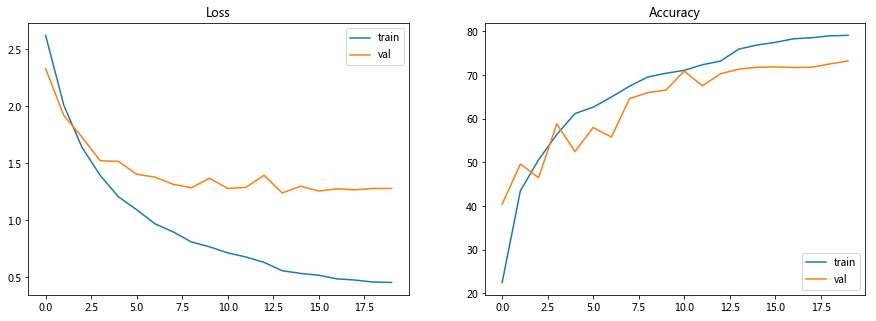

In [39]:
# 画出性能
trainer.plot_performance()

In [40]:
# 测试集性能
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 1.30
Test Accuracy: 71.0%
